# Efficient frontier

This notebook illustrates the application of Harry Markowitz’s (1952) approach to optimal portfolio selection.

First, let us import the libraries we are going to use.


In [1]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
import matplotlib.pyplot as plt
import datetime

Also, it is our preference to use ggplot - like style, and Helvetica font.  

In [37]:
from matplotlib import style
import matplotlib as mpl
import matplotlib.font_manager as fm

style.use('seaborn-whitegrid')

font_dirs = ['Font', ]
font_files = fm.findSystemFonts(fontpaths=font_dirs)
font_list = fm.createFontList(font_files)
fm.fontManager.ttflist.extend(font_list)

mpl.rcParams['font.family'] = 'Lato'

# Set colors
my_colors = {'DBlue':'#424f64', 'LBlue':'#a4afc0', 'BrBlue':'#85c7f2', 'DGrey':'#4c4c4c', 'MGrey':'#636363', 
             'DRed':'#961e19', 'LGrey':'#d1d1d1'}

### Dataset

First, let us upload the data. The dataset we are using comprises daily observations of major asset classes indices.

Some indices were initially designed as monthly indices. Therefore, to preserve more data, we convert daily observations into monthly observations. We truncate the dataset so that it starts on Jan 31, 1992. On this date, we have all the indices recorded.


Next we calculate monthly returns.

In [3]:
df = pd.read_csv('Data/indices.csv', index_col=0, parse_dates=True) # read the dataset

df = df.resample('M').last() # convert into monthly observations

df = df.loc['1992-12-31':,:]  #truncate the dataset

df = (df - df.shift(1)) / df.shift(1) #Calculate monthly returns

df = df.iloc[1:,:]  # remove first row of NaNs


Here is how our dataset looks like now

In [4]:
df.head(5)

,SP500,EuroStoxx50,MSCI_EM,TotalBond,Treasury,CorpBond,CorpHY,DJRE,WTI,Gold
Date,,,,,,,,,,
1993-01-31,0.007046,0.009714,0.004001,0.019176,0.021462,0.023300,0.029081,0.046364,0.038974,-0.005979
1993-02-28,0.010484,0.081271,0.015940,0.017505,0.020059,0.022957,0.017634,0.021312,0.016782,-0.009023
1993-03-31,0.018697,0.011043,0.031348,0.004167,0.003318,0.003496,0.012863,0.078687,-0.007767,0.028832
1993-04-30,-0.025417,-0.023290,0.017567,0.006963,0.007849,0.007698,0.008725,-0.040679,0.004403,0.050147
1993-05-31,0.022717,-0.000494,0.019370,0.001273,-0.001225,0.001178,0.011882,0.004862,-0.024842,0.075843


The indices we use in our analysis are the following:

*Equities:*
- SP500 - S&P 500
- EuroStoxx50 - EuroStoxx 50 (European stock market)
- MSCI_EM - MSCI Emerging Markets

*Fixed Income:*
- TotalBond -  Barclays Capital U.S. Aggregate Bond Index
- Treasury - Barclays U.S. Treasury Bond Index
- CorpHY - Barclays U.S. Corporate High Yield Bonds 
- CorpBond - Barclays U.S. Corporate Investment Grade Bonds 

*Real Estate:*
- DJRE - Dow Jones Global Real Estate

*Commodities:*
- WTI - WTI Oil prices 
- Gold - Gold prices 


### Risk vs. Return

One of the key premises of the modern portfolio theory is that the assets should be evaluated on the ratio of the expected return and expected risk, measured as a standard deviation of returns.

In our further analysis, for illustration purposes, we use historical returns and risk as proxies of the expected returns and risk. One can argue that with the absence of the crystal ball, long-term historical return can be viewed as an optimal measure.
Let us plot the annualized return and risk characteristics of each asset class.


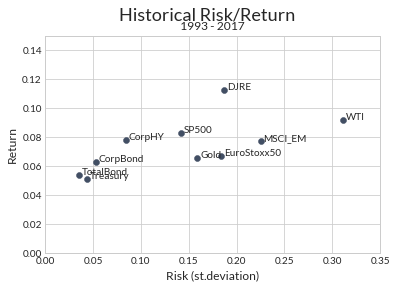

In [28]:
# Calculate annualized returns
mean_df = df.mean()*12   

#Calculate annualized risk
stdev_df = df.std()*((12)**(1/2)) 

#Create dataframe for the plot
for_plot = pd.DataFrame([mean_df,stdev_df], index=['Return', 'Risk']).T   

#Scatter plot
plt.scatter(for_plot.Risk, for_plot.Return, c=my_colors['DBlue'], label=for_plot.columns) 
    
    
# Put labels
labels = list(for_plot.index.values)
    
for label, x, y in zip(labels, for_plot.Risk, for_plot.Return):
    plt.annotate(
            label,
            xy=(x, y), xytext=(3,3),
            textcoords='offset points', ha='left', va='center')


#Make it pretty (Title, subtitles, axes lables)
plt.suptitle('Historical Risk/Return', fontsize=18)
plt.title('1993 - 2017', fontsize=12)
plt.xlabel('Risk (st.deviation)', fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.xlim(0,0.35)
plt.ylim(0, 0.15)

#Save graph for future use
plt.savefig('Graphs/Risk_Return_93_17.png', dpi=300)


### Asset portfolio

According to the modern portfolio theory, when assets are combined in a portfolio, we can extract the benefits of diversification. This feature results from the fact that the return of the portfolio is calculated as a weighted average return, while risk calculation takes into account the correlation among the assets.

For simplicity, let us illustrate it with the portfolio of two assets.

Portfolio return is calculated as: 

$$
\begin{align*}
\\
R_p & = w_1R_1 + w_2R_2\qquad\ , where \\
\\
R_p &- portfolio\space return\\
w_1, w_2 &- weights\space of\space assets\space in\space the\space portfolio\\
R_1, R_2 &- returns\space of\space assets\space in\space the\space portfolio\\
\\
\\
\end{align*}
$$

Risk, or standard deviation of returns, is calculated as: 

$$
\begin{align*}
\\
\sigma_p & = \sqrt{w^2_1\sigma^2_1 + w^2_2\sigma^2_2 + 2w_1w_2\rho_{1,2}\sigma_1\sigma_2}\qquad , where \\
\\
\sigma_p &- portfolio\space standard\space deviation\space of\space returns\\
w_1, w_2 &- weights\space of\space assets\space in\space the\space portfolio\\
\sigma_1, \sigma_2 &- standard\space deviation\space of\space asset\space returns\space in\space the\space portfolio\\
\rho_{1,2} &- correlation\space between\space asset\space returns
\\
\\
\end{align*}
$$


By plugging in the formula for correlation, we can rewrite the equation as:
$$
\begin{align*}
\\
\sigma_p & = \sqrt{w^2_1\sigma^2_1 + w^2_2\sigma^2_2 + 2w_1w_2Cov_{1,2}}\qquad , where \\
\\
Cov_{1,2} &- covariance\space of\space asset\space returns
\\
\\
\end{align*}
$$

For multiple assets, the portfolio return calculation is quite straightforward:

$$
\begin{align*}
\\
R_p & = \sum_{i=1}^{n} w_i * R_i \\
\\
\\
\end{align*}
$$

Or in a matrix form:
$$
\begin{align*}
\\
R_p & = W^TR\space, where \\
\\
\\
W &- is\space an\space array\space of\space asset\space weights\\
R &- is\space an\space array\space of\space asset\space returns\\
\\
\\
\end{align*}
$$

The calculation of the portfolio standard deviation is better done via matrix algebra:

$$
\begin{align*}
\\
\sigma_p & = \sqrt{W^TCW} \qquad\ , where \\\\
W &- array\space of\space asset\space weights\\
C &- asset\space returns\space covariance\space matrix\\
\\
\\
\end{align*}
$$





Let us define a Python function that calculates portfolio return and standard deviation of returns.

In [29]:
def calcPortPerformance(weights, mean_ret, cov_matrix):
    '''
    This function calculates portfolio return and risk (standard deviation of returns)
    
    ARGUMENTS:
    weights - array of asset weights in the portfolio. Must sum up to 1.0
    mean_ret - array of assets mean returns. Better to use annualized
    cov_matrix - covariance matrix of assets returns. Better to use annualized
    
    
    OUTPUT:
    A tuple containing:
    portRet - portfolio return
    portRisk - portfolio risk
       
    '''
    
    
    portRet = weights.T.dot(mean_ret)
    portRisk = np.sqrt(weights.T.dot(cov_matrix.dot(weights)))
    
    return portRet, portRisk
        
    

For illustration, let's calculate the portfolio performance, assuming we held:
- 60% in S&P500
- 30% in Total Bond Index
- 10% in DJRE (Real estate)

For simplicity, we assume that we bought this portfolio on Jan 1, 1993, and held it until December 31, 2017, without any rebalancing.

In [30]:
df_tmp = df.loc[:, ['SP500','TotalBond','DJRE']]   #Select assets

weights = np.array([0.6, 0.3, 0.1])
mean_ret = df_tmp.mean() * 12  #Annualized mean return
stdev_ret = df_tmp.std() *(np.sqrt(12)) # Annualized st dev of returns
cov_matrix = df_tmp.cov() * 12 #Annualized covariance matrix


#Calculate portfolio performance
portRet, portRisk = calcPortPerformance(weights, mean_ret, cov_matrix)


#Create a pretty dataframe for comparison
port_df = pd.DataFrame({'Portfolio':[portRet, portRisk]}, index = ['Return','Risk'])

result = pd.DataFrame([mean_ret.T, stdev_ret.T], index = ['Return','Risk']).join(port_df)

result


,SP500,TotalBond,DJRE,Portfolio
Return,0.083054,0.053917,0.112414,0.077249
Risk,0.141611,0.035343,0.187218,0.098387


As you can see, combining assets into a portfolio significantly decreased the risk, and less so the return of the portfolio.

The combined portfolio has an annual return of 7.7% with a standard deviation of returns of 9.8%. Thus, the portfolio return is not much lower than the stock return for the period (9.8%), while the risk of the portfolio is significantly lower than the stock market risk (14.2%).


### Efficient frontier

We can combine different assets in a number of various portfolios.

Let us numerically simulate risk and return profiles of portfolios comprised of:

- S&P 500 Index
- Total Bond Index
- DJRE (Real Estate)

We will keep using monthly returns for the period 1993 – 2017. All results will be annualized for convenience.

In [31]:
def simPortfolios(mean_ret, cov_matrix, nsim=10000, constrained = True):
    '''
    This function simulates portfolio return and risk for varios random portfolio weights distributions.
    
      
    ARGUMENTS:
    mean_ret - array of assets mean returns. Better to use annualized
    cov_matrix - covariance matrix of assets returns. Better to use annualized
    nsim - number of simulations. By default - 10000 simulations
    constrained - boolean. If True, the portfolio weights are constrained to sum-up to 1
    
    OUTPUT:
    result - resulting dataframe with columns 'Return' and 'Risk' for each simulation. Return and risk are annualized 
             portfolio return and risk.  
    
    
    DEPENDENCIES:
    - calcPortPerformance
    
    '''
    
    n_assets = mean_ret.shape[0] #Get number of assets
    

    #Create empty DataFrame
    result = pd.DataFrame({'Return': [None] * nsim,
                           'Risk': [None] * nsim})
    
    #Simulate portfolios performance and populate the resulting dataframe
    if constrained:
        for i in range(nsim):
            weights = np.random.rand(n_assets)  #Simulate normal distribution
            weights = weights/sum(weights)      #Make sure that weights add up to 1.0
        
            portRet, portRisk = calcPortPerformance(weights, mean_ret, cov_matrix)
        
            result.iloc[i, :] = [portRet, portRisk]
            
    else:
        for i in range(nsim):
            weights = np.random.uniform(-1,1,n_assets)  #Simulate normal distribution
        
            portRet, portRisk = calcPortPerformance(weights, mean_ret, cov_matrix)
        
            result.iloc[i, :] = [portRet, portRisk]
    
    return result

        

Let's simulate and plot portfolio returns and risk. 

*This step may take some time (you can take a coffee break, while it is calculating).*

In [34]:
np.random.seed(123) #Set seed for replicability

df_tmp = df.loc[:, ['SP500','TotalBond','DJRE']]   #Select assets

n_assets = df_tmp.shape[1] 

mean_ret = df_tmp.mean() * 12  #Annualized mean return
stdev_ret = df_tmp.std() *(np.sqrt(12)) # Annualized st dev of returns
cov_matrix = df_tmp.cov() * 12 #Annualized covariance matrix

port_combinations_constrained = simPortfolios(mean_ret, cov_matrix, nsim=30000, constrained=True)  #Simulate return and risk



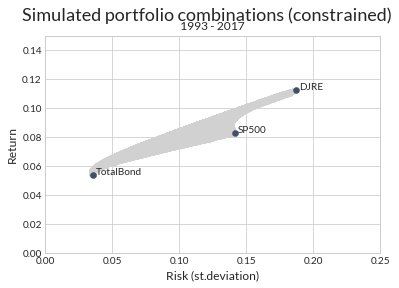

In [39]:
#Scatter plot of possible combinations (unconstrained)
plt.scatter(port_combinations_constrained.Risk, port_combinations_constrained.Return, c=my_colors['LGrey'], label=for_plot.columns) 

#Scater plot of asset returns and risks (100% portfolio weights)
for_plot = pd.DataFrame([mean_ret,stdev_ret], index=['Return', 'Risk']).T   

#Scatter plot
plt.scatter(for_plot.Risk, for_plot.Return, c=my_colors['DBlue'], label=for_plot.columns) 
    
# Put labels
labels = list(for_plot.index.values)
    
for label, x, y in zip(labels, for_plot.Risk, for_plot.Return):
    plt.annotate(
            label,
            xy=(x, y), xytext=(3,3),
            textcoords='offset points', ha='left', va='center')

    
#Make it pretty (Title, subtitles, axes lables)
plt.suptitle('Simulated portfolio combinations (constrained)', fontsize=18)
plt.title('1993 - 2017', fontsize=12)
plt.xlabel('Risk (st.deviation)', fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.xlim(0,0.25)
plt.ylim(0, 0.15)

#Save graph for future use
plt.savefig('Graphs/Port_Comb_constr_93_17.png', dpi=300)

The upper bound of our simulation represents the “Efficient Frontier,” a combination of portfolios that offer maximum return for a given risk.

Finding the weights of assets on the Efficient Frontier is an optimization problem, where for a given level of return we find the optimal portfolio weights that minimize the variance. This optimization task for the unconstrained portfolio has a closed-form solution.

First, we find minimum variance corresponding to a target portfolio return taking into account asset returns and covariance.


$$
\begin{align*}
\\
\sigma_{p}^2 & = \lambda_1 + \lambda_2R \\
\\
\\\lambda_1 &= \dfrac{c - b\mu_p} {\Delta}
\\\lambda_2 &= \dfrac{a\mu_p - b} {\Delta}
\\
\\a & = \mathbf{1}^T\Sigma^{-1}\mathbf{1}
\\b & = R^T\Sigma^{-1}\mathbf{1}
\\c & = R^T\Sigma^{-1}R
\\\Delta &= ac - b^2 
\\
\\,& where \\
\\
\sigma_{p}^2 &- portfolio\space variance
\\R &- array\space of\space portfolio\space asset\space returns\\
\Sigma &- asset\space returns\space covariance\space matrix\\
\mu_p &- target\space portfolio\space return\\
\\
\\
\end{align*}
$$

Knowing the minimum variance for the given portfolio return, we can now calculate the weights of the assets on the efficient frontier as:

$$
\begin{align*}
\\
\\ W &= \Sigma^{-1}(\lambda_1\mathbf1 + \lambda_2\mu)
\\
\\
\end{align*}
$$

On the Efficient Frontier, we can find two important portfolios that can be used for asset allocation:
- *Minimum Variance Portfolio (MVP)*. As the name suggests, it is the - portfolio with the lowest standard deviation of retuns.
- *Tangency Portfolio (TP)* is the portfolio with the highest Sharpe ratio, calculated for an asset with return $r_i$ and standard deviation of returns $\sigma_i$, and for a risk-free rate $r_f$ as $\dfrac{r_i - r_f}{\sigma_i}$

Both portfolios' combinations also have closed-form solutions:

$$
\begin{align*}
\\
\\ W_{mvp} &= \dfrac{\Sigma^{-1}\mathbf1}{\mathbf1^T\Sigma^{-1}\mathbf1}\\
\\ W_{tp} &= \dfrac{\Sigma^{-1}\hat{\mu}}{\mathbf1^T\Sigma^{-1}\hat{\mu}}
\\
\\\hat{\mu} & = R - r_f\cdot{\mathbf1} \space, where
\\
\\W_{mvp}, W_{tp}  &- asset\space weights\space in\space MVP \space and\space TP\space respectively 
\\r_f &- risk\space free\space rate\\
\\
\\
\end{align*}
$$



If you would like to learn more about the derivation of the formula above, you can find a number of publications on the optimization tasks in the modern portfolio theory. Some examples include:
- https://faculty.washington.edu/ezivot/econ424/portfolioTheoryMatrix.pdf
- https://ocw.mit.edu/courses/mathematics/18-s096-topics-in-mathematics-with-applications-in-finance-fall-2013/lecture-notes/MIT18_S096F13_lecnote14.pdf

Please be aware that the authors of these publications can use slightly different notations of the variables.



In [36]:
def findEfficientFrontier(mean_ret, cov_matrix, target_ret):
    '''
    Funnction that calculates efficient frontier through the optimization process.

    ARGUMENTS:
    mean_ret - array of assets mean returns. Better to use annualized
    cov_matrix - covariance matrix of assets returns. Better to use annualized
    ret - range of returns for which we find efficient frontier portfolios 

    OUTPUT:
    ef_Risk - standard deviation of efficient portfolio expected returns
    w_ef - array of efficient portfolio weights in a given return range
   
    '''
    
    mu = np.array(mean_ret).reshape((len(mean_ret),1))
    Sigma_inv = np.linalg.inv(cov_matrix)  #Find inverse of covariance matrix
    ones = np.ones((len(mean_ret),1))      #Array of ones
    
    #Calculate constants
    a = float(ones.T.dot(Sigma_inv).dot(ones))
    b = float(mean_ret.T.dot(Sigma_inv).dot(ones))
    c = float(mean_ret.T.dot(Sigma_inv).dot(mean_ret))
    
    #Calculate delta
    delta = a*c - b**2
    
    #Calculate lambdas
    lambda_1 = (c - b * target_ret) / delta 
    lambda_2 = (a*target_ret - b) / delta
    
    #Find expected variance of the efficiant portfolio
    ef_Var = lambda_1 + lambda_2 * target_ret
    ef_Risk = np.sqrt(ef_Var)
    
    
    #Find EF weights
    
    w_ef = Sigma_inv.dot(np.multiply(lambda_1,ones) + np.multiply(lambda_2,mu))
        
        
    return ef_Risk, w_ef 


def findMVPort(mean_ret, cov_matrix):
    '''
    Funnction that finds minimum variance portfolio.

    ARGUMENTS:
    mean_ret - array of assets mean returns. Better to use annualized
    cov_matrix - covariance matrix of assets returns. Better to use annualized
    

    OUTPUT:
    w_mv - array of asset weights
     
    '''
    Sigma_inv = np.linalg.inv(cov_matrix)  #Find inverse of covariance matrix
    ones = np.ones((len(mean_ret),1))      #Array of ones
    
    #Calculate weights in minimum variance portfolio
    w_m = Sigma_inv.dot(ones) / ones.T.dot(Sigma_inv.dot(ones))
    
    return w_m
    
    
def findTangPort(mean_ret, cov_matrix, rf_rate):
    '''
    Funnction that finds minimum variance portfolio.

    ARGUMENTS:
    mean_ret - array of assets mean returns. Better to use annualized
    cov_matrix - covariance matrix of assets returns. Better to use annualized
    rf_rate - risk-free rate

    OUTPUT:
    w_tp - array of asset weights
    
    '''
    
    Sigma_inv = np.linalg.inv(cov_matrix)  #Find inverse of covariance matrix
    ones = np.ones((len(mean_ret),1))      #Array of ones
    mu_hat = np.array(mean_ret).reshape((len(mean_ret), 1)) - np.multiply(rf_rate, ones)
    
    
    
    #Calculate weights in minimum variance portfolio
    w_tp = Sigma_inv.dot(mu_hat) / ones.T.dot(Sigma_inv.dot(mu_hat))
    
    return w_tp
    

Using the same portfolio example, we can calculate and plot the Efficient Frontier, TP, and MVP.

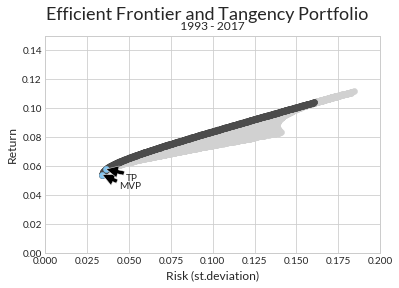

In [41]:
n_points = 500                            #Number of points on the EF line

#Calculate risk-free rate
ff_factors = pd.read_csv('Data/ff_factors.csv', index_col=0, parse_dates=True)  # Load Fama French factors (http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html)
rf = 1 + ff_factors['RF'] / 100  #Get daily RF rate
rf = rf.groupby([rf.index.year, rf.index.month]).cumprod() - 1   #Calculate compounded monthly rf return
rf = rf.resample('M').last() * 12  # Calculate anualized rf return
rf = rf.loc['1993':'2017']   #Keep only relevant observations
rf = rf.mean()                 # Calculate mean rf rate
rf_rate = float(rf)

#Find miminum variance portfoio
w_m = findMVPort(mean_ret, cov_matrix)
mv_Ret, mv_Risk = calcPortPerformance(w_m, mean_ret, cov_matrix)

#Find tangency portfolio
w_tp = findTangPort(mean_ret, cov_matrix, rf_rate)
tp_Ret, tp_Risk = calcPortPerformance(w_tp, mean_ret, cov_matrix)


range_ret = np.linspace(mv_Ret, mv_Ret + 0.05, n_points)   #Set return range

# EF LINE
EL_Risk = []   #Place holders


for ret in range_ret:
    ef_Risk,ef_weights = findEfficientFrontier(mean_ret, cov_matrix, ret)
    EL_Risk.append(ef_Risk)
  
#Plot frontier and portfolios
plt.scatter(port_combinations_constrained.Risk, port_combinations_constrained.Return, c=my_colors['LGrey'], label=for_plot.columns) 
plt.scatter(EL_Risk, range_ret, color = my_colors['DGrey'])
plt.scatter(mv_Risk, mv_Ret, color =  my_colors['BrBlue'])
plt.scatter(tp_Risk, tp_Ret, color =  my_colors['BrBlue'])

#Annotate portfolios

plt.annotate('MVP', xy=(float(mv_Risk), float(mv_Ret)), 
             xytext=(float(mv_Risk)+0.01, float(mv_Ret)-0.01),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )

plt.annotate('TP', xy=(float(tp_Risk), float(tp_Ret)), 
             xytext=(float(tp_Risk)+0.012, float(tp_Ret)-0.008),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )

#Make it pretty (Title, subtitles, axes lables)
plt.suptitle('Efficient Frontier and Tangency Portfolio', fontsize=18)
plt.title('1993 - 2017', fontsize=12)
plt.xlabel('Risk (st.deviation)', fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.xlim(0,0.20)
plt.ylim(0, 0.15)

#Save graph for future use
plt.savefig('Graphs/EF_TP_93_17.png', dpi=300)


    

### Security Market Line

Harry Markowitz’s (1952) dissertation paper titled "Portfolio Selection" introduced the concept of the efficient frontier. Later, in 1958, James Tobin suggested including risk-free assets in the analysis of the portfolio selection. Traditionally, researchers use the U.S. Treasury bill yield as a proxy for the risk-free rate of return.

In 1964, William Sharpe introduced the notion of the Security Market Line (SML) as a combination of the risk-free rate asset and a market portfolio. The idea is that we can take the most efficient portfolio, the tangency portfolio, and adjust expected risk/return profile by borrowing or lending at the risk-free rate of return.

Graphically, the resulting combination of portfolios looks like this SML line.

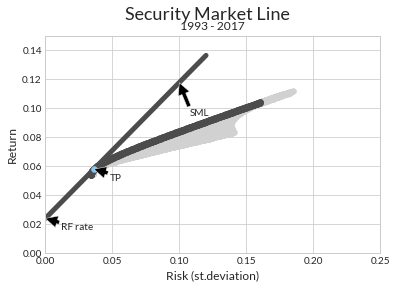

In [50]:
# Calculate SML
sml = pd.DataFrame({'Risk':np.linspace(0,0.12,100)})      # Create a placeholder for SML line
sml_slope = (float(tp_Ret) - rf) / float(tp_Risk)  #Calculate SML line slope
sml['Return'] = rf + sml_slope * sml['Risk']            # Build SML line returns


#Plot SML
plt.scatter(port_combinations_constrained.Risk, port_combinations_constrained.Return, c= my_colors['LGrey'], label=for_plot.columns) 
plt.scatter(EL_Risk, range_ret, color =  my_colors['DGrey'])
plt.plot(sml.Risk, sml.Return, color = my_colors['DGrey'], lw=5, zorder=1)
plt.scatter(tp_Risk, tp_Ret, color =  my_colors['BrBlue'], zorder=2)

#Annotate portfolios

plt.annotate('TP', xy=(float(tp_Risk), float(tp_Ret)), 
             xytext=(float(tp_Risk)+0.012, float(tp_Ret)-0.008),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )


plt.annotate('RF rate', xy=(0, rf), 
             xytext=(0 + 0.012, rf -0.008),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )


#Find SML x,y coordinates
sml_x = 0.1
sml_y = rf + sml_slope * sml_x 


plt.annotate('SML', xy=(sml_x, sml_y), 
             xytext=(sml_x+0.008, sml_x-0.005),
            arrowprops=dict(facecolor='black', shrink=0.005),
            )


#Make it pretty (Title, subtitles, axes lables)
plt.suptitle('Security Market Line', fontsize=18)
plt.title('1993 - 2017', fontsize=12)
plt.xlabel('Risk (st.deviation)', fontsize=12)
plt.ylabel('Return', fontsize=12)
plt.xlim(0,0.25)
plt.ylim(0, 0.15)

#Save graph for future use
plt.savefig('Graphs/SML_93_17.png', dpi=300)

We can see that by combining risk-free rate and the tangency portfolio, we can theoretically create leveraged portfolios that deliver better return at the given level of risk compared to portfolios on the Efficient Frontier. Alternatively, we can say that some combinations of leveraged tangency portfolios deliver the same expected return as portfolios on the Efficient Frontier, but with lower expected risk.

### Challenges of practical implementation

So far, the theory looks nice and coherent. However, the main challenge in the direct implementation of this approach to portfolio selection is that we do not know the future risk and return profiles of various asset classes. Relying just on historical values creates a risk of suboptimal asset allocation.

To illustrate it, let us assume that we again hold the portfolio of S&P500, TotalBond Index, and Corporate High Yield Bonds index. Now let's see how the combination of the tangency portfolio would have changed for each 5-year subperiod in our sample


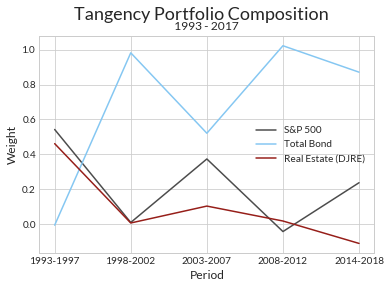

In [51]:
start_years = np.linspace(1993, 2014, 5).astype('int')  # Set beginning of the period

#Calculate RF rate
rf = 1 + ff_factors['RF'] / 100  #Get daily RF rate
rf = rf.groupby([rf.index.year, rf.index.month]).cumprod() - 1   #Calculate compounded monthly rf return
rf = rf.resample('M').last() * 12  # Calculate anualized rf return


#Create dataframe with tangency portfolio weights
tp_df = pd.DataFrame(columns=df_tmp.columns)  #Placeholder


#Loop over periods
for i in range(len(start_years)):
    tmp = df_tmp.loc[str(start_years[i]) : str(start_years[i] + 4),:] # Select period
    
    mean_ret = tmp.mean() * 12     # Calculate mean returns
    cov_matrix = tmp.cov() * 12    # Calculate covariance matrix
    
    tmp_index = str(start_years[i]) + '-' + str(start_years[i] + 4) #Create names for the graph
        
    #Find RF rate for the period
    rf_rate = rf.loc[str(start_years[i]) : str(start_years[i] + 4)]   #Keep only relevant observations
    rf_rate = rf_rate.mean()                 # Calculate mean rf rate
    rf_rate = float(rf_rate)
    
    #Find tangency portfolio composition
    w_tp = findTangPort(mean_ret, cov_matrix, rf_rate)
        
    #Create data frame for the plot
    tp_df = tp_df.append(pd.DataFrame(w_tp.reshape((1,len(df_tmp.columns))), 
                                      index = [tmp_index], columns=df_tmp.columns))
        

#Plot weights
plt.plot(tp_df['SP500'], color=my_colors['DGrey'], label='S&P 500')
plt.plot(tp_df['TotalBond'], color=my_colors['BrBlue'], label='Total Bond')
plt.plot(tp_df['DJRE'], color=my_colors['DRed'], label='Real Estate (DJRE)')


#Make it pretty (Title, subtitles, axes lables)
plt.suptitle('Tangency Portfolio Composition', fontsize=18)
plt.title('1993 - 2017', fontsize=12)
plt.xlabel('Period', fontsize=12)
plt.ylabel('Weight', fontsize=12)
plt.legend()

#Save graph for future use
plt.savefig('Graphs/TP_composition.png', dpi=300)


### Conclusion

The modern portfolio theory presents a framework for efficient asset allocation.

Financial data is notoriously non-stationary, i.e., the distribution of asset returns changes with time. Therefore, we should keep in mind that the theory operates with expected asset returns and expected risk. Using historical data may lead to suboptimal allocation decisions.

Having said that, once we have a view on future distribution returns, the theory will allow us to calculate the optimal portfolio weights. This way we maximize the expected portfolio return for a given level of risk.
Another important takeaway is the ability to create leveraged portfolios beyond the Efficient Frontier by utilizing the Tangency Portfolio. We will talk more about the Security Market Line in the post dealing with CAPM and Smart Betas.


### References

*1. Markowitz, Harry. "Portfolio selection." The journal of finance 7.1 (1952): 77-91.*

*2. Sharpe, William F. "Capital asset prices: A theory of market equilibrium under conditions of risk." The journal of finance 19.3 (1964): 425-442.*

*3. Tobin, James. "Liquidity preference as behavior towards risk." The review of economic studies 25.2 (1958): 65-86.*


### Reminder

**If you choose to use this publication for your own work, please include a reference to this publication and a link leading to this document. **

### Disclaimer

**Not an Offer or Inducement**

*This publication has been prepared for informational purposes only and does not constitute an offer to sell, a solicitation of an offer to buy, or a recommendation of any security or any other product or service by QFL Capital LLC., QFL Holdings Inc., authors of the publication, or any other third party regardless of whether such security, product or service is referenced in this publication. None of the information or analyses presented are intended to form the basis for any investment decision, and no specific recommendations are intended.*

*Accordingly, this publication does not constitute investment advice or counsel or solicitation for investment in any security. This publication does not constitute or form part of, and should not be construed as, any offer for sale or subscription of, or any invitation to offer to buy or subscribe for, any securities, nor should it or any part of it form the basis of, or be relied on in any connection with, any contract or commitment whatsoever.*

*QFL Capital LLC., QFL Holdings Inc., and authors of the publication expressly disclaim any and all responsibility for any direct or consequential loss or damage of any kind whatsoever arising directly or indirectly from: (i) the use of this site; (ii) reliance on any information contained herein; (iii) any error, omission or inaccuracy in any such information; or (iv) any action resulting therefrom.*


**Investment Performance**

*Investors should seek financial advice regarding the appropriateness of investing in any securities or investment strategies discussed or recommended in this documentation and should understand that statements regarding future prospects may not be realized. Investors should note that income from such securities may fluctuate and that each security's price or value may rise or fall. Accordingly, investors may receive back less than originally invested.*

*Past performance is not necessarily a guide to future performance. In consideration of being permitted access to the publication, the viewer hereby acknowledges having read and understood this agreement and agrees to be bound by its terms and conditions.*

**No Warranties**

*QFL Capital LLC., QFL Holdings Inc., and authors of the publication take care to ensure that the information provided is accurate and up to date. However, this document is provided without warranties of any kind, either expressed or implied, including but not limited to warranties of title or implied warranties of merchantability or fitness for a particular purpose. Opinions expressed herein are subject to change without notice. All information and content on this publication is furnished "as is," without warranty of any kind, express or implied, including but not limited to implied warranties of merchantability, fitness for a particular purpose, or non-infringement.*